# Context of the problem

Cintas is a company that delivers clean uniforms to customers around the city.  While GPS can help navigate routes in real-time, route planning is done in advance based on sequencing stops based on geographical considerations. In fact, after speaking with a representative, I found that they plan routes entirely on zipcodes. The zipcode of a series of stops is not always the greatest predictor of what will complete the series of stops in the least amount of time. Can we predict traffic issues before they occur so that we may avoid them?

We will explore the Real-Time Traffic Incident Reports from Austin's Open Data Portal.
(https://data.austintexas.gov/Transportation-and-Mobility/Real-Time-Traffic-Incident-Reports/dx9v-zd7x)

# Steps Taken

1. Latitude and Longitude now both float data types

2. Null values removed with little impact on number of rows

3. Traffic Report ID, Status columns removed

4. Scope of coordinates slightly reduced for a more realistic representation of the city

5. The issue_timespan column was engineered (in minutes) and the status_date column was dropped

6. Issues with negative resolution times or times beyond 24 hours were removed

7. The number of classes in the issue_reported column was reduced from 23 to 8 through either combining similar labels or dropping the class entirely due to a lack of instances

8. Addresses & Location columns deemed less reliable/useful than coordinate data and removed

9. No relationship between high volume coordinates and issue timespan was found

10. There were correlations between coordinates and certain classes of issue reported

11. There were coorelations between issue reported and timespan

12. After visualizing incident timespan by volume, it was determined that works best for this dataset is dealing with issues that took less than 8 hours to resolve (480 minutes)

13. Day of week feature added and indicates that there is a spike in incident volume on Friday and a dip on Sunday

14. Hour of day feature added indicating that there is an increase in issue timespan between the hours of 6:00 am and 11:00 am

15. Month feature added indicating that there is an increase in issue timespan the first three month of the year

16. Region and latitudinal/longitudinal distance from center features added indicating that the volume of incidents is generally higher in the north and in the east.

# Choosing and Training a Model

In this notebook I will try and predict what kind of an incident occured. If we can predict this accurately we may also have some insights into where it took place and how long it took to resolve. 

Target: issue_reported(y)



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.cluster
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, fbeta_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

Import data of clean features

In [2]:
file = '/Users/tshields/Documents/GitHub/Real-Time_Traffic_Incident_Reports/FeatureEngineering/feature_engineering4.csv'

In [3]:
df = pd.read_csv(file, index_col=0)
df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km
0,2018-06-13 06:35:59+00:00,Crash Service,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),Wednesday,6,June,cnw,ne,1.849061
1,2018-06-13 10:15:36+00:00,Traffic Hazard,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),Wednesday,10,June,vne,ne,9.009002
2,2020-04-17 21:25:03+00:00,Crash Service,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),Friday,21,April,vce,ne,12.228301
3,2020-04-17 21:40:52+00:00,Traffic Hazard,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),Friday,21,April,vsw,sw,7.357232
4,2020-04-17 21:00:55+00:00,Crash Service,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),Friday,21,April,vse,se,10.665180


In [4]:
df.describe()

,Latitude,Longitude,issue_timespan,hour,dist_cntr_km
count,243114.000000,243114.000000,243114.000000,243114.000000,243114.000000
mean,30.301716,-97.733273,72.641459,13.659287,11.826093
std,0.093666,0.086736,90.826579,7.055001,7.320069
min,30.004413,-98.226709,0.333333,0.000000,0.007638
25%,30.232036,-97.776903,20.766667,9.000000,6.040102
50%,30.294241,-97.734390,41.316667,15.000000,10.961410
75%,30.373598,-97.687501,81.166667,19.000000,16.959760
max,30.798642,-97.293320,480.000000,23.000000,60.669983


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243114 entries, 0 to 243113
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   published_date  243114 non-null  object 
 1   issue_reported  243114 non-null  object 
 2   Latitude        243114 non-null  float64
 3   Longitude       243114 non-null  float64
 4   issue_timespan  243114 non-null  float64
 5   geometry        243114 non-null  object 
 6   day             243114 non-null  object 
 7   hour            243114 non-null  int64  
 8   month           243114 non-null  object 
 9   region          243114 non-null  object 
 10  quadrant        243114 non-null  object 
 11  dist_cntr_km    243114 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 24.1+ MB


In [6]:
df['issue_reported'].unique()

array(['Crash Service', 'Traffic Hazard', 'Collision', 'Stalled Vehicle',
       'Loose Livestock', 'Traffic Impediment'], dtype=object)

#  Use Label Encoder for categorical data we are trying to predict
Trying to predict the "issue_reported" involves transforming the column using LabelEncoder(). Then a quick check to ensure the numbers line up like before.

In [7]:
le = LabelEncoder()
df['issue_reported']=le.fit_transform(df['issue_reported'])
df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km
0,2018-06-13 06:35:59+00:00,1,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),Wednesday,6,June,cnw,ne,1.849061
1,2018-06-13 10:15:36+00:00,4,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),Wednesday,10,June,vne,ne,9.009002
2,2020-04-17 21:25:03+00:00,1,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),Friday,21,April,vce,ne,12.228301
3,2020-04-17 21:40:52+00:00,4,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),Friday,21,April,vsw,sw,7.357232
4,2020-04-17 21:00:55+00:00,1,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),Friday,21,April,vse,se,10.665180


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243114 entries, 0 to 243113
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   published_date  243114 non-null  object 
 1   issue_reported  243114 non-null  int64  
 2   Latitude        243114 non-null  float64
 3   Longitude       243114 non-null  float64
 4   issue_timespan  243114 non-null  float64
 5   geometry        243114 non-null  object 
 6   day             243114 non-null  object 
 7   hour            243114 non-null  int64  
 8   month           243114 non-null  object 
 9   region          243114 non-null  object 
 10  quadrant        243114 non-null  object 
 11  dist_cntr_km    243114 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 24.1+ MB


In [9]:
df['issue_reported'].unique()

array([1, 4, 0, 3, 2, 5])

In [10]:
df['issue_reported'].value_counts()

1    93808
4    93012
0    32536
3    11965
2     5914
5     5879
Name: issue_reported, dtype: int64

## Apply LabelEncoder on the other categorical columns.

In [11]:
le2 = LabelEncoder()
df['region']=le2.fit_transform(df['region'])
le3 = LabelEncoder()
df['day']=le3.fit_transform(df['day'])
le4 = LabelEncoder()
df['month']=le4.fit_transform(df['month'])
le5 = LabelEncoder()
df['quadrant']=le5.fit_transform(df['quadrant'])
df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km
0,2018-06-13 06:35:59+00:00,1,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),6,6,6,2,0,1.849061
1,2018-06-13 10:15:36+00:00,4,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),6,10,6,8,0,9.009002
2,2020-04-17 21:25:03+00:00,1,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),0,21,0,6,0,12.228301
3,2020-04-17 21:40:52+00:00,4,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),0,21,0,11,3,7.357232
4,2020-04-17 21:00:55+00:00,1,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),0,21,0,10,2,10.665180


## Scaling Timespan and Latitude/Longitude Features
First, create a series variable using .values

In [12]:
series1 = df.issue_timespan.values
series2 = df.dist_cntr_km.values

Then reshape the series to scale it as 2D arrays

In [13]:
series1 = series1.reshape(-1,1)

In [14]:
series2 = series2.reshape(-1,1)

In [15]:
scaler = StandardScaler()

Then create new columns for for each of the series.

In [16]:
df['scaled_timespan'] = scaler.fit_transform(series1)

In [17]:
df['scaled_dist_km'] = scaler.fit_transform(series2)

In [18]:

df.head()

,published_date,issue_reported,Latitude,Longitude,issue_timespan,geometry,day,hour,month,region,quadrant,dist_cntr_km,scaled_timespan,scaled_dist_km
0,2018-06-13 06:35:59+00:00,1,30.283797,-97.741906,144.066667,POINT (-97.741906 30.283797),6,6,6,2,0,1.849061,0.786393,-1.362973
1,2018-06-13 10:15:36+00:00,4,30.339593,-97.700963,64.450000,POINT (-97.700963 30.339593),6,10,6,8,0,9.009002,-0.090188,-0.384846
2,2020-04-17 21:25:03+00:00,1,30.329455,-97.638105,30.000000,POINT (-97.638105 30.329455),0,21,0,6,0,12.228301,-0.469483,0.054946
3,2020-04-17 21:40:52+00:00,4,30.202806,-97.760701,14.183333,POINT (-97.760701 30.202806),0,21,0,11,3,7.357232,-0.643625,-0.610496
4,2020-04-17 21:00:55+00:00,1,30.184265,-97.687339,149.150000,POINT (-97.68733899999999 30.184265),0,21,0,10,2,10.665180,0.842360,-0.158594


## One Hot Encoding

In [19]:
dummies = pd.get_dummies(df, columns=['day','hour','month','region', 'quadrant'])

In [20]:
dummies = dummies.drop(columns=['issue_reported', 'issue_timespan', 'Latitude','Longitude', 'geometry', 
                                'published_date', 'dist_cntr_km'])

In [21]:
dummies.head()

,scaled_timespan,scaled_dist_km,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_0,...,region_6,region_7,region_8,region_9,region_10,region_11,quadrant_0,quadrant_1,quadrant_2,quadrant_3
0,0.786393,-1.362973,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,-0.090188,-0.384846,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
2,-0.469483,0.054946,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,-0.643625,-0.610496,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0.842360,-0.158594,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [22]:
X = dummies

In [23]:

y = df.issue_reported

In [24]:
X.shape

(243114, 61)

In [25]:
y.shape

(243114,)

## Train Test Split and Scale

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [27]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Running Default Models and Comparing Algorithms
X and y are set so all models can be fit through these two variables. I will fit three models and see which is most accurate. The four models will be KNN, Random Forest and Decision Tree.

In [28]:
models = []

models.append(('RFC', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GradientBoostingClassifier()))


In [29]:
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5, random_state=None)
    cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RFC: 0.561074 (0.029347)
DT: 0.478183 (0.021309)
NB: 0.580966 (0.033176)


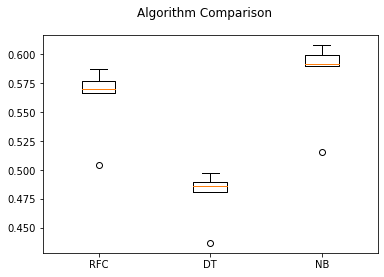

In [30]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Naive Bayes Accuracy and F1 Scores

In [31]:
gbc = GradientBoostingClassifier(random_state = 1)
model_res = gbc.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)

print('Naive Bayes: Accuracy=%.3f' % (ac))

print('Naive Bayes: f1-score=%.3f' % (f1))

print('Naive Bayes: Balanced Accuracy=%.3f' % (ba))


Random Forest: Accuracy=0.584
Random Forest: f1-score=0.561
Random Forest: Balanced Accuracy=0.345


## Random Forest Accuracy and F1 Scores

In [32]:
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print('Random Forest: Balanced Accuracy=%.3f' % (ba))

Random Forest: Accuracy=0.571
Random Forest: f1-score=0.551
Random Forest: Balanced Accuracy=0.343


## Random Forest Hyperparamter Tuning


The Random Forest default performed best. Now to find the best parameters to tune.

In [33]:
forest = RandomForestClassifier()

In [34]:
n_estimators = [120, 300, 500, 800]
max_depth = [5, 8, 15, 25]
min_samples_split = [2, 5, 10, 15]


hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             )

gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [35]:
print('Best n_estimators:', bestF.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', bestF.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', bestF.best_estimator_.get_params()['min_samples_split'])

Best n_estimators: 500
Best max_depth: 25
Best min_samples_split: 15


In [36]:
forestOpt = RandomForestClassifier(random_state = 1, max_depth = 25, n_estimators = 500, min_samples_split = 15)
                                   
modelOpt = forestOpt.fit(X_train, y_train)
y_pred = modelOpt.predict(X_test)

## A confusion matrix on Random Forest model

In [38]:
class_names=['Crash Service', 'Traffic Hazard', 'Stalled Vehicle', 'COLLISION', 'LOOSE LIVESTOCK', 
             'Traffic Impediment'] # name  of classes

Confusion matrix, without normalization
[[ 5777   950   106     0  2930     0]
 [  601 19092     3     0  8615     0]
 [  980    76   197     0   531     0]
 [  133   991     1     1  2410     0]
 [ 2204  7560    93     1 17904     0]
 [   23   872     0     0   884     0]]
Normalized confusion matrix
[[5.92e-01 9.73e-02 1.09e-02 0.00e+00 3.00e-01 0.00e+00]
 [2.12e-02 6.74e-01 1.06e-04 0.00e+00 3.04e-01 0.00e+00]
 [5.49e-01 4.26e-02 1.10e-01 0.00e+00 2.98e-01 0.00e+00]
 [3.76e-02 2.80e-01 2.83e-04 2.83e-04 6.82e-01 0.00e+00]
 [7.94e-02 2.72e-01 3.35e-03 3.60e-05 6.45e-01 0.00e+00]
 [1.29e-02 4.90e-01 0.00e+00 0.00e+00 4.97e-01 0.00e+00]]


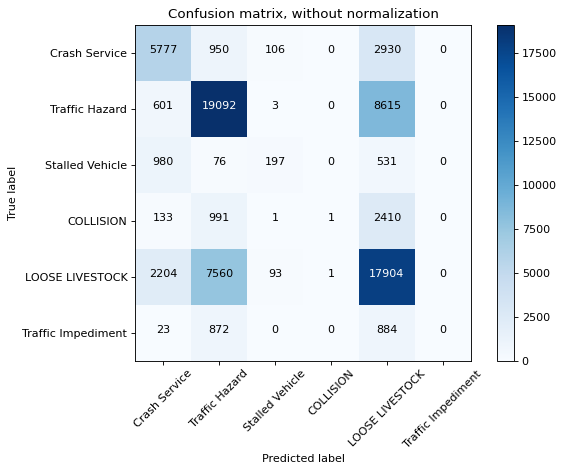

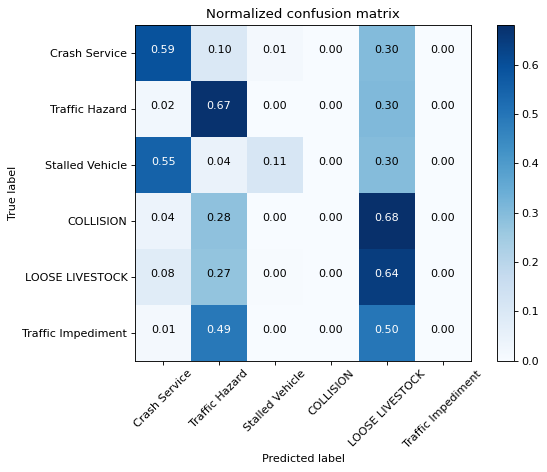

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    #for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6), dpi=80)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

There appears to be 3 classes in particular that stand out:

Crash Service

Traffic Hazard

Loose Livestock

# What were the most important variables?

30


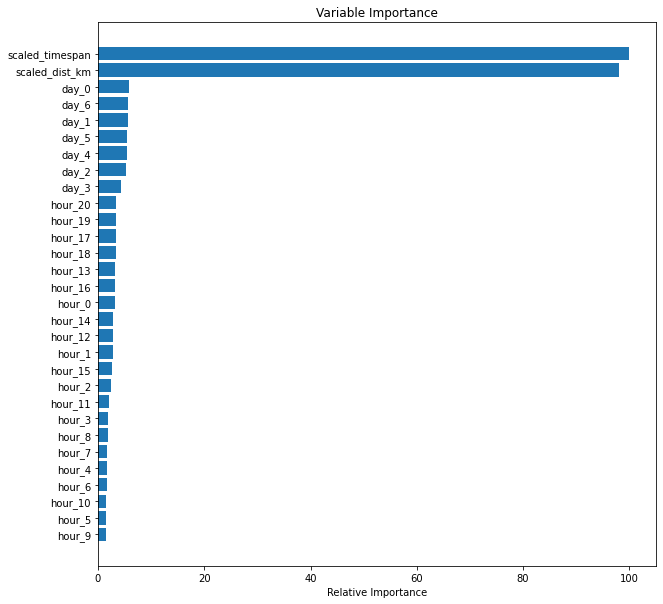

In [40]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [41]:
df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
df

,Real Values,Predicted Values
43,1,1
146776,1,1
96622,4,1
87263,0,4
112654,1,1
...,...,...
117431,0,4
238726,1,4
49844,5,1
152669,4,4


# Running Reports

In [42]:
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
ba = balanced_accuracy_score(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

print('Random Forest: Balanced Accuracy=%.3f' % (ba))

Random Forest: Accuracy=0.571
Random Forest: f1-score=0.563
Random Forest: Balanced Accuracy=0.337
